In [ ]:
import os
import sys
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.4-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")


## Create SparkContext, SparkSession
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = sc.textFile("/user/Data/StreamDataPred/Data*/*")

In [ ]:
data.count()

7247

In [ ]:
data.take(3)

[u'(\'"2/28/2017 0:00:00",40.8039,-73.9678,"B02764"\', 6)',
 u'(\'"2/28/2017 0:00:00",40.7319,-73.9964,"B02764"\', 0)',
 u'(\'"2/28/2017 0:03:00",40.7497,-73.9875,"B02764"\', 3)']

In [ ]:
import re
#lines = data.map(lambda x: re.sub('\(|\)', '', str(x)))
lines = data.map(lambda x: re.sub('\'', '', str(x)))

In [ ]:
lines.take(3)

['("2/28/2017 0:00:00",40.8039,-73.9678,"B02764", 6)',
 '("2/28/2017 0:00:00",40.7319,-73.9964,"B02764", 0)',
 '("2/28/2017 0:03:00",40.7497,-73.9875,"B02764", 3)']

In [ ]:
lines1 = lines.map(lambda x: re.sub('\(', '', str(x)))

In [ ]:
lines2 = lines1.map(lambda x: re.sub('\)', '', str(x)))

In [ ]:
lines2.take(3)

['"2/28/2017 0:00:00",40.8039,-73.9678,"B02764", 6',
 '"2/28/2017 0:00:00",40.7319,-73.9964,"B02764", 0',
 '"2/28/2017 0:03:00",40.7497,-73.9875,"B02764", 3']

In [ ]:
lines2.take(3)

['"2/28/2017 0:00:00",40.8039,-73.9678,"B02764", 6',
 '"2/28/2017 0:00:00",40.7319,-73.9964,"B02764", 0',
 '"2/28/2017 0:03:00",40.7497,-73.9875,"B02764", 3']

In [ ]:
data1 = lines2.map(lambda line: line.split(','))

In [ ]:
data1.take(2)

[['"2/28/2017 0:00:00"', '40.8039', '-73.9678', '"B02764"', ' 6'],
 ['"2/28/2017 0:00:00"', '40.7319', '-73.9964', '"B02764"', ' 0']]

In [ ]:
clusterList = data1.map(lambda line : int(line[4])).collect()

In [ ]:
def constructBarGraph(listDetails,xLabel,yLabel):
    barGraphDict = dict((x,listDetails.count(x)) for x in set(listDetails))
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(xLabel)
    ax1.set_ylabel(yLabel)
    plt.bar(range(len(barGraphDict)), barGraphDict.values(), align='center')
    plt.xticks(range(len(barGraphDict)), barGraphDict.keys())
    plt.show()

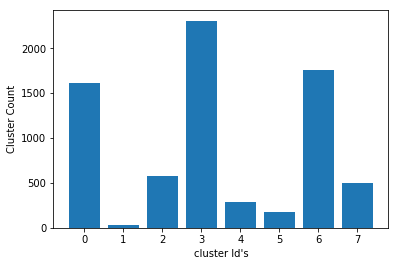

In [ ]:
## clusternumber vs count of data poinst in each cluster
constructBarGraph(clusterList, 'cluster Id\'s','Cluster Count')

In [ ]:
hr = data1.map(lambda line : line[0]).map(lambda x: re.sub('\'', '', str(x)))

In [ ]:
hr.take(2)

['"2/28/2017 0:00:00"', '"2/28/2017 0:00:00"']

In [ ]:
def covnertTSToHour(value):
    if value and not value.isspace():
        #value = "2/28/2017 0:00:00"
        time = value.split(" ")[1].split(":")
        return int(time[0])

In [ ]:
hrlist = hr.map(lambda hr:covnertTSToHour(hr)).collect()

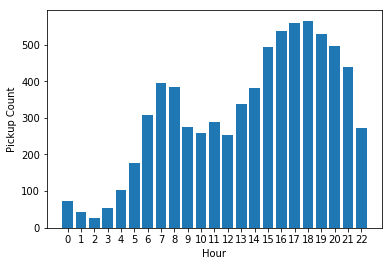

In [ ]:
## plot the bar chart for hour of day vs count of pick-up requests for each hour
## Plot the hour list details
constructBarGraph(hrlist,'Hour','Pickup Count')

In [ ]:
import pandas as pd

In [ ]:
FinalData = pd.DataFrame(
    {'Cluster_Id': clusterList,
     'Hour_of_Day': hrlist
    })

In [ ]:
FinalData.head(6)

,Cluster_Id,Hour_of_Day
0,6,0
1,0,0
2,3,0
3,0,0
4,0,0
5,2,0


In [ ]:
ClusterIdHourData = FinalData.groupby(['Cluster_Id','Hour_of_Day'])

In [ ]:
len(ClusterIdHourData)

177

In [ ]:
type(ClusterIdHourData)

pandas.core.groupby.DataFrameGroupBy

In [ ]:
## Convert the above as a data frame
ClusterHourFrame = ClusterIdHourData.size().to_frame()

In [ ]:
type(ClusterHourFrame)

pandas.core.frame.DataFrame

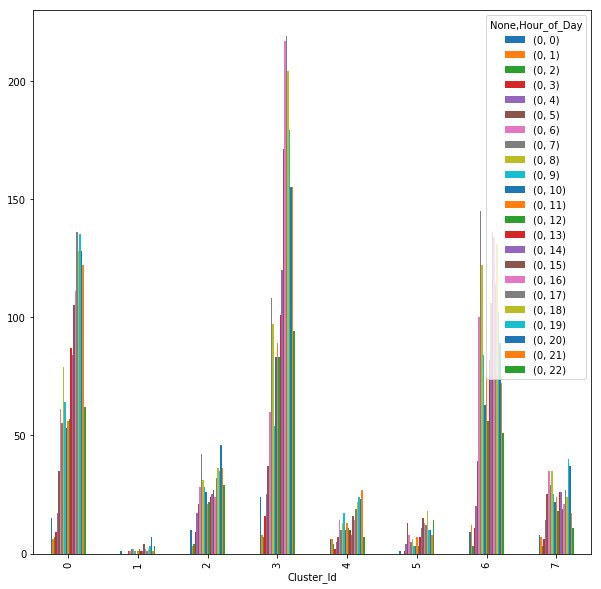

In [ ]:
## Stacked bar chart for the above
ClusterHourFrame.unstack(level=-1).plot(kind='bar', figsize = (10,10))

In [ ]:
## Filter the records based on the clusterId
def drawPlotPerGraph(clusterNo):
    Data0Rec = FinalData[FinalData['Cluster_Id']==clusterNo]
    ax = Data0Rec.groupby(['Hour_of_Day']).size().to_frame().unstack(level=-1).plot(kind='bar', figsize = (10,10),title='Cluster ' + str(clusterNo)  + ' Hour Of Day Distribution')
    ax.set_xlabel("Hour Of Day")
    ax.set_ylabel("Cluster Count")
    ax.set_xticklabels(range(0,24))
    plt.show()

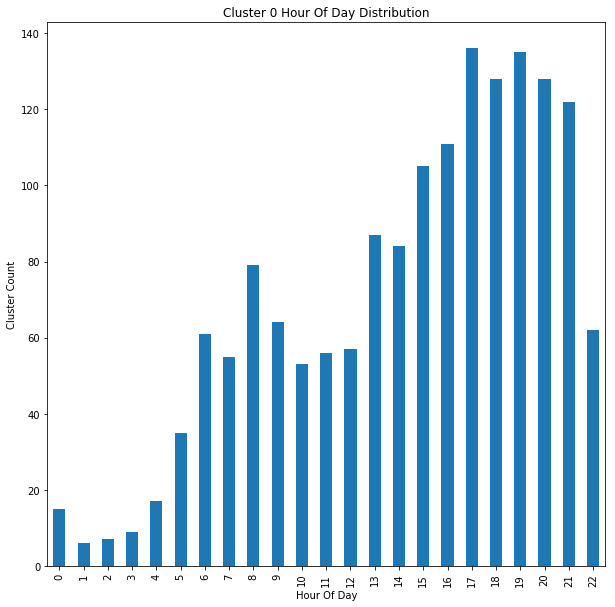

In [ ]:
## count for each hour for cluster 0
drawPlotPerGraph(0)

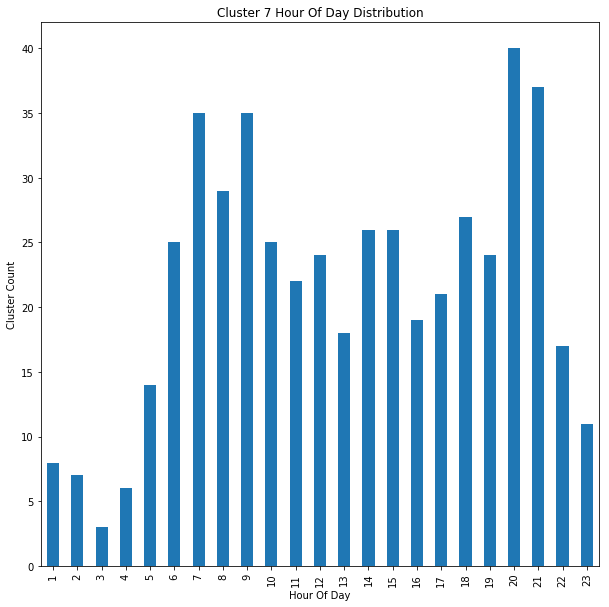

In [ ]:
drawPlotPerGraph(7)